# Cleaning The Open PV dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
Over the past 10 years, installation costs for solar energy technology have dropped an astonishing 60%¹. This form of renewable energy is more accessible now than ever before. Yet over that same period, soft costs, such as sales and marketing, have remained almost completely stagnant. According to the Solar Energy Industries Association (SEIA), in Q4 2016, soft costs accounted for 67% of installation costs for residential solar². This has moved the impetus for growth in the solar industry from the development of cheaper technologies to a focus on ways to attack soft costs by more efficiently spreading information to potential solar customers.

<img src="http://www.seia.org/sites/default/files/Fig4-SolarPVPriceBreakdown-2017YIR.png" style="width:700px;height:400px;">

### Data

Data for this project came from two sources, both managed by the NREL. The first is The OpenPV Project, which contains data related to over one million solar panel installations across the U.S. This dataset includes the following:
Annual energy production
- Installation cost
- Size
- Orientation
- Tilt
- Installer
- Technology type
- etc.

The OpenPV data was simply downloaded in CSV format from the NREL website, located here: https://openpv.nrel.gov/search

### Solar Data

The second dataset comes from the National Solar Radiation Database (NSRDB) API. This dataset includes hourly measures of:
- Radiation
- Temperature
- Wind speed
- Position of the sun

The NSRDB API only allows one thousand daily queries, so in order to gather local radiation data for the roughly fifteen thousand ZIP codes in the OpenPV dataset, I wrote a python script, set it to run every twenty-four hours, and deployed it on a remote Amazon Web Services EC2 instance. The script pulled hourly data from all of 2015 (the most recent data available), averaged it for the year, and saved it to a local MySQL database. Once I had pulled down radiation data for all one million solar panel installations, I merged the two datasets according to ZIP code, the most granular location measure available.

Below is the script used to gather radiation data.


<a id='wrangling'></a>
## Data Cleaning
> - Load and check data
    - load data
    - check for null and missing values
    - Outlier detection

### General Properties

In [1]:
# Import Libararies
import pandas as pd
import numpy as np

In [2]:
# Load Data
df = pd.read_csv("./openpv_all.csv")
df.head(3)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (2,5,8,12,13,14,15,16,20,23,25,26,27,28,32,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,new_constr,effic_1,cust_county,tracking,inv_model_clean,mod_cost_real,inv_cost_real,bos_powerclerk_real,permitting_real,3rdparty
0,TX,12/12/2013,Austin Energy,uir,10.56,NaN,78702.0,residential,NaN,2.897777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TX,07/11/2014,Austin Energy,uir,12.72,NaN,78702.0,residential,NaN,3.144654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TX,01/17/2014,Austin Energy,uir,5.40,NaN,78702.0,residential,NaN,4.197330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 81 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           797958 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean 

### Checking for non null values

In [4]:
# Check for Null values
df.isnull().sum()

state                                0
date_installed                       5
incentive_prog_names            222757
type                                 5
size_kw                              5
appraised                       796679
zipcode                              5
install_type                     42581
installer                       318068
cost_per_watt                   257582
cost                            257421
lbnl_tts_version_year           222757
lbnl_tts                        222757
city                            221567
utility_clean                   227995
tech_1                          439796
model1_clean                    439796
county                           22063
annual_PV_prod                  239746
annual_insolation               239746
rebate                          634017
sales_tax_cost                  665406
tilt1                           637350
tracking_type                   494657
azimuth1                        657434
manuf2_clean             

> There are loads of non null data. The best decision is to get rid of them

In [5]:
df.shape

(1020715, 81)

In [6]:
# Getting rid of columns where there's no data

# first getting a list all the column names where there's no data.
non_null_cols = [col for col in df.columns if df[col].notnull().sum() != 0]

In [7]:
# limiting the dataframe to just non-null columns
df = df[non_null_cols]

In [8]:
df.isnull().sum()

state                                0
date_installed                       5
incentive_prog_names            222757
type                                 5
size_kw                              5
appraised                       796679
zipcode                              5
install_type                     42581
installer                       318068
cost_per_watt                   257582
cost                            257421
lbnl_tts_version_year           222757
lbnl_tts                        222757
city                            221567
utility_clean                   227995
tech_1                          439796
model1_clean                    439796
county                           22063
annual_PV_prod                  239746
annual_insolation               239746
rebate                          634017
sales_tax_cost                  665406
tilt1                           637350
tracking_type                   494657
azimuth1                        657434
manuf2_clean             

In [9]:
df.shape

(1020715, 39)

> There were 42 columns with non null values

### Incentive Program Names
> These are probably pretty important to determining cost, so let's see if we can find some trend to impute it.

In [24]:
# There are a bunch of these incentive programs, which almost definitely have an influence on people's eventual cost of solar.
df['incentive_prog_names'].value_counts()

California Public Utilities Commission (Non-CSI Net Metered Systems)          260940
no_incentive_program                                                          222757
California Public Utilities Commission (California Solar Initiative)          148988
New York State Energy Research and Development Authority                       44012
Arizona Public Service                                                         40647
Massachusetts Clean Energy Center                                              36810
New Jersey Board of Public Utilities (SREC Program)                            34168
California Energy Commission (Emerging Renewables Program)                     27952
Massachusetts Department of Energy Resources                                   24828
Los Angeles Department of Water & Power                                        19757
California Energy Commission (New Solar Homes Partnership)                     17286
Connecticut Clean Energy Finance and Investment Authority        

### Let's look at average cost_per_watt for these different commisions: 

In [12]:
# import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

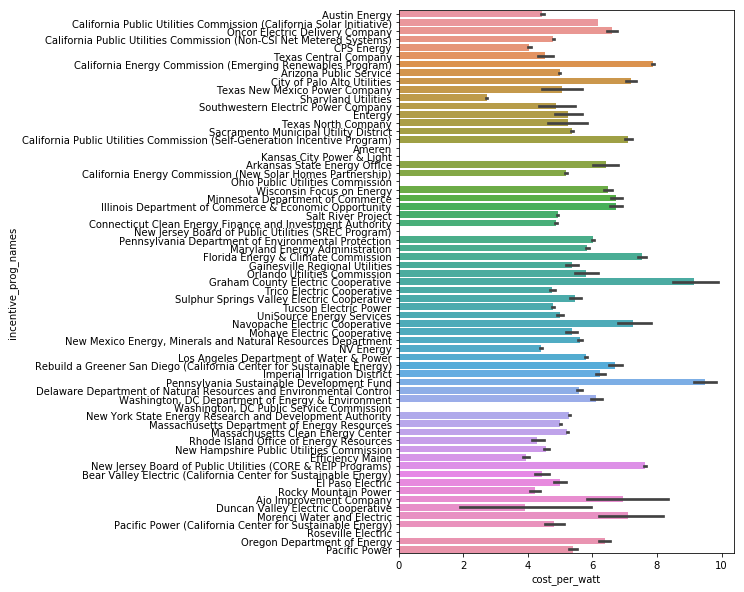

In [13]:
# There's definitely some variance around this, and it looks like within each of these the variance or price 
# is pretty tight.

fig = plt.figure(figsize=(6,10))

sns.barplot(x=df["cost_per_watt"], y=df["incentive_prog_names"], orient = 'h')

> Either values where the incentive is blank means they didn't have an incentive program, or that 
it isn't listed.  If it's not listed, maybe we can impute it.

In [14]:
null_incentive_state = df.loc[df['incentive_prog_names'].isnull(), :].groupby("state").size()

In [21]:
# looking at proportion by state with no incentive program compared to with incentive program may provide some clues
list(zip(null_incentive_state.sort_values(ascending=False).index, sorted(null_incentive_state/sum(null_incentive_state), reverse=True)))

[('CA', 0.6050539376989276),
 ('AZ', 0.07783818241402066),
 ('MA', 0.04391781178593714),
 ('NJ', 0.03949595298913165),
 ('CT', 0.03545118671916034),
 ('NY', 0.03145580161341731),
 ('TX', 0.021404490094587374),
 ('PA', 0.019016237424637608),
 ('MD', 0.0178176218929147),
 ('CO', 0.011698846725355433),
 ('HI', 0.010432893242412136),
 ('DE', 0.00943629156435039),
 ('OR', 0.008731487674910329),
 ('NM', 0.008210740852139327),
 ('VT', 0.007371261060258488),
 ('NV', 0.00681460066350328),
 ('DC', 0.006711349138298684),
 ('WI', 0.005454374048851439),
 ('FL', 0.00492015963583636),
 ('IN', 0.004098636630947624),
 ('TN', 0.0026980072455635514),
 ('NH', 0.0026576044748313184),
 ('MN', 0.0024376338341780507),
 ('UT', 0.0017373191414860138),
 ('IL', 0.0016834487805097035),
 ('OH', 0.0016430460097774705),
 ('LA', 0.0015487728780689272),
 ('MO', 0.0015128593040847202),
 ('MI', 0.0011851479414788312),
 ('WA', 0.0009382421203374081),
 ('IA', 0.0009247745300933304),
 ('WY', 0.0007048038894400624),
 ('ME', 

In [22]:
notnull_incentive_state = df.loc[df['incentive_prog_names'].notnull(), :].groupby("state").size()

list(zip(notnull_incentive_state.sort_values(ascending=False).index, sorted(notnull_incentive_state/sum(notnull_incentive_state), reverse=True)))

[('CA', 0.6166239325879307),
 ('AZ', 0.09025788324698794),
 ('MA', 0.07724466701254953),
 ('NY', 0.05515578514157387),
 ('NJ', 0.05294639567496034),
 ('CT', 0.01973286814594252),
 ('NV', 0.01820897841741044),
 ('TX', 0.012011910401299317),
 ('MD', 0.009363901358216848),
 ('PA', 0.00906438684742806),
 ('NM', 0.008179628501750719),
 ('MO', 0.006475278147471421),
 ('DE', 0.003787166743111793),
 ('NH', 0.003645555279851822),
 ('OR', 0.0029262191744427652),
 ('WI', 0.0026392366515530894),
 ('OH', 0.0024036352790497745),
 ('FL', 0.002366039315352437),
 ('DC', 0.0022570110206301583),
 ('IL', 0.0013923038555913971),
 ('MN', 0.001287035157238852),
 ('ME', 0.0006905125332410979),
 ('RI', 0.0006779805453419854),
 ('UT', 0.0005388754796618368),
 ('AR', 0.00012281348141130236)]

> Looks like some states don't even show up, probably safe to assume that those states just don't have incentive programs. 
Given that, it seems like it may be difficult to distingush between cases where there was no incentive program available and where it was unreported.

In [23]:
# Fill no_incentive_program where incentive_prog_names is missing
df['incentive_prog_names'].fillna("no_incentive_program", inplace=True)

### Utility_Clean

> By looking at the data I think that utility_clean is going to be heavily linked to states and/or counties, we can probably impute this by grabbing the mode value from each state or county.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 39 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           1020715 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean

In [26]:
df.groupby(['state', 'utility_clean']).size()

state  utility_clean                              
AR     Carroll Electric Coop Corp                         1
       Carroll Electric Coop Corp - (AR)                  1
       Entergy Arkansas Inc                              61
       Oklahoma Gas & Electric Co                         3
       Southwestern Electric Power Co                    32
AZ     Ajo Improvement Company                            3
       Arizona Public Service                         40647
       Duncan Valley Electric Cooperative                 5
       Graham County Electric Cooperative               129
       Mohave Electric Cooperative                      449
       Morenci Water and Electric                         3
       Navopache Electric Cooperative                   140
       Salt River Project                             15275
       Sulphur Springs Valley Electric Cooperative     1266
       Trico Electric Cooperative                      1357
       Tucson Electric Power                     

> We can already see that there's quite a bit of deviation within states, for instance a lof of CA is on Los Angeles Department of Water & Power, and a lot is on Pacific Gas & Electric Co, maybe county will help.

In [29]:
# grouping the state, country and utility_clean together to get a better view
county_utilities = pd.DataFrame(df.groupby(['state', 'county', 'utility_clean']).size()).reset_index()
county_utilities

,state,county,utility_clean,0
0,AR,Benton,Southwestern Electric Power Co,6
1,AR,Boone,Entergy Arkansas Inc,3
2,AR,Carroll,Entergy Arkansas Inc,4
3,AR,Chicot,Entergy Arkansas Inc,1
4,AR,Crawford,Oklahoma Gas & Electric Co,2
5,AR,Faulkner,Entergy Arkansas Inc,3
6,AR,Franklin,Oklahoma Gas & Electric Co,1
7,AR,Garland,Entergy Arkansas Inc,4
8,AR,Grant,Entergy Arkansas Inc,2
9,AR,Hempstead,Entergy Arkansas Inc,1


> This looks quite a bit better, looks like in most counties there's only one or maybe 2 utilities that people are on.

In [30]:
# Looking at california (As we have seen that it have different utility)
county_utilities[county_utilities['state'] == "CA"]

,state,county,utility_clean,0
71,CA,Alameda,Pacific Gas & Electric Co,191
72,CA,Alameda,Pacific Gas & Electric Company,16285
73,CA,Alameda,Port of Oakland,1
74,CA,Alameda,Southern California Edison,5
75,CA,Amador,Pacific Gas & Electric Co,1
76,CA,Amador,Pacific Gas & Electric Company,663
77,CA,Butte,Pacific Gas & Electric Co,76
78,CA,Butte,Pacific Gas & Electric Company,5383
79,CA,Butte,Southern California Edison,1
80,CA,Calaveras,Pacific Gas & Electric Company,1047


> This looks pretty robust, I'm also noticing that there's a ton of double labled names e.g. **'Pacific Gas & Electric Co' and "Pacific Gas & Electric Company"**. Let's chnage this.

In [31]:
# changing some misnamed PG&E values

df.loc[df['utility_clean'] == "Pacific Gas & Electric Co", 'utility_clean'] = "Pacific Gas & Electric Company"

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 39 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           1020715 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean

In [36]:
a = df.head(100).utility_clean

In [44]:
a.mode()[0]

'Oncor Electric Delivery Company'

In [45]:
# cleaning up some bad state entries.

df.loc[df['state'] == 'PA ', 'state'] = 'PA'
df.loc[df['state'] == 'MD ', 'state'] = 'MD'
df.loc[df['state'] == 'OH ', 'state'] = "OH"

> There are a few states where there's no listing.  let's just fill the states where there are some utility listings, and fill the other ones with "no utility listed"

In [49]:
states = list(df.state.unique())

for state in states:
    non_nulls = df.loc[df['state'] == state, 'utility_clean'].notnull().sum()
    if non_nulls == 0:
        df.loc[df['state'] == state, 'utility_clean'] = "no utility listed"
    else:
        mode_utility = df.loc[df['state'] == state, 'utility_clean'].value_counts().index[0]
        mask = (df['state'] == state) & (df['utility_clean'].isnull())
        df.loc[mask, 'utility_clean'] = mode_utility
        
print(df['utility_clean'].isnull().sum())

0


In [50]:
df.loc[df['state'] == 'CA', 'utility_clean'].isnull().sum()

0

In [51]:
df.groupby(['state', 'utility_clean']).size()

state  utility_clean                              
AK     no utility listed                                 22
AL     no utility listed                                 32
AR     Carroll Electric Coop Corp                         1
       Carroll Electric Coop Corp - (AR)                  1
       Entergy Arkansas Inc                             202
       Oklahoma Gas & Electric Co                         3
       Southwestern Electric Power Co                    32
AZ     Ajo Improvement Company                            3
       Arizona Public Service                         57986
       Duncan Valley Electric Cooperative                 5
       Graham County Electric Cooperative               129
       Mohave Electric Cooperative                      449
       Morenci Water and Electric                         3
       Navopache Electric Cooperative                   140
       Salt River Project                             15275
       Sulphur Springs Valley Electric Cooperativ

> Looks like the utility is clean. Save the data base.

In [52]:
df.to_csv("open_pv_clean.csv")

In [53]:
# Read the new database
df = pd.read_csv("open_pv_clean.csv")

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (6,9,10,12,13,14,16,17,21,24,26,27,28,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
df.head()

,Unnamed: 0,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,...,reported_annual_energy_prod,year,pbi_length,utility,bipv_3,bipv_2,bipv_1,new_constr,tracking,3rdparty
0,0.0,TX,12/12/2013,Austin Energy,uir,10.560,NaN,78702.0,residential,NaN,...,13836.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,TX,07/11/2014,Austin Energy,uir,12.720,NaN,78702.0,residential,NaN,...,16419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,TX,01/17/2014,Austin Energy,uir,5.400,NaN,78702.0,residential,NaN,...,7235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,IN,10/06/2017,no_incentive_program,uir,6.785,NaN,47403.0,Residential,Whole Sun Designs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,IN,10/06/2017,no_incentive_program,uir,4.720,NaN,47408.0,Residential,Whole Sun Designs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020718 entries, 0 to 1020717
Data columns (total 40 columns):
Unnamed: 0                     1020715 non-null float64
state                          1020718 non-null object
date_installed                 1020712 non-null object
incentive_prog_names           1020717 non-null object
type                           1020713 non-null object
size_kw                        1020713 non-null float64
appraised                      224039 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763136 non-null object
cost                           763294 non-null float64
lbnl_tts_version_year          797959 non-null object
lbnl_tts                       797959 non-null object
city                           799149 non-null object
utility_clean                  1020713 non-null object
tech_1     

In [57]:
df.install_type.value_counts()

residential                    728661
Residential                    179452
commercial                      24470
Unknown                         15771
Commercial                      11943
unknown                          4034
government                       3721
nonprofit                        3003
Government                       2027
educational                      1703
Nonprofit                        1217
Educational                       710
Customer                          371
Agricultural                      312
education                         290
Utility                           138
agricultural                      124
utility                            92
Institutional                      29
Commercial - Other                 16
Gov't/NP                           11
Public                             11
Residential/SF                      5
public                              5
agriculture                         5
Nonresidential                      3
Not Stated  

> Looks like there's a lot of improperly install_type names. If we just make them all lower case that will help. 
We can also probably safely impute the empty values with residential.

In [58]:
# setting it all to lower case
df['install_type'] = [install.lower() for install in df['install_type'].astype(str)]

In [59]:
# consolidating commercial
df['install_type'] = ['commercial' if "commercial" in install else install for install in df['install_type']]

In [60]:
df['install_type'] = ['educational' if "educat" in install else
                      'commercial' if 'commer' in install else
                      'public' if "gov't" in install else
                      'residential' if '/sf' in install else
                      'agricultural' if 'agricu' in install else
                      'public' if install == 'municipal' 
                      else install for install in df['install_type']]

In [61]:
df['install_type'].value_counts()

residential       908118
nan                42584
commercial         36434
unknown            19805
government          5748
nonprofit           4220
educational         2703
agricultural         441
customer             371
utility              230
institutional         29
public                28
nonresidential         3
not stated             2
small business         2
Name: install_type, dtype: int64

> There are lot of random name. Let's make some of the random one's nan and get rid of small-business.

In [62]:
nan_labels = ['nonresidential', 'not stated', 'unknown', 'customer']

df['install_type'] = ['nan' if install in nan_labels else
                     'commercial' if 'small business' in install else
                     install for install in df['install_type']]

In [63]:
df['install_type'].value_counts()

residential      908118
nan               62765
commercial        36436
government         5748
nonprofit          4220
educational        2703
agricultural        441
utility             230
institutional        29
public               28
Name: install_type, dtype: int64

> Residential have the most value counts and it  seriously dominates the others by a large number, but maybe there's some big trend we can use to imput the nan.

In [64]:
df['install_type'] = [np.nan if install == 'nan' else install for install in df['install_type']]

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


(0, 20000)

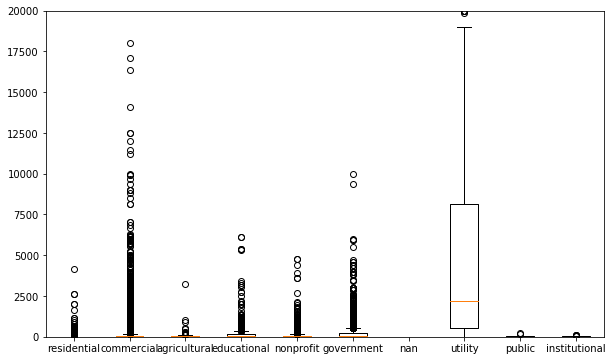

In [66]:
fig = plt.figure(figsize=(10,6))

data = [df.loc[df['install_type'] == install, 'size_kw'] for install in df['install_type'].unique()]
plt.boxplot(data, labels = df['install_type'].unique())
plt.ylim(0,20000)

> It's kind of hard to get anything out of this, also nan and residential are just not even showing up.

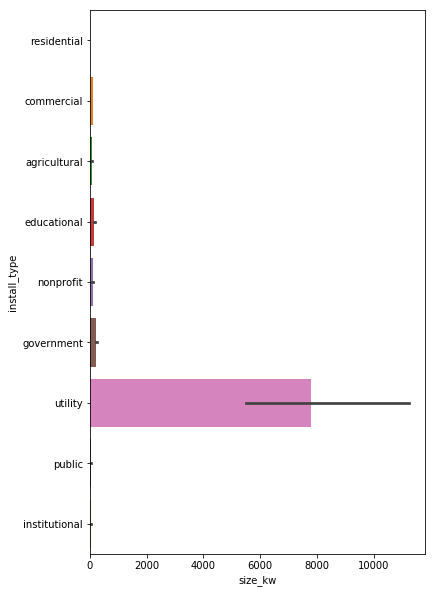

In [67]:
fig = plt.figure(figsize=(6,10))
sns.barplot(y=df['install_type'], x=df['size_kw'], orient='h')

> It looks like anything larger than the max government one we can for sure say is utility. So, we have to ge rid of utility to see anything else.

In [68]:
utility_cutoff = df.loc[df['install_type'] == 'utility', 'size_kw'].max()
utility_cutoff

333000.0

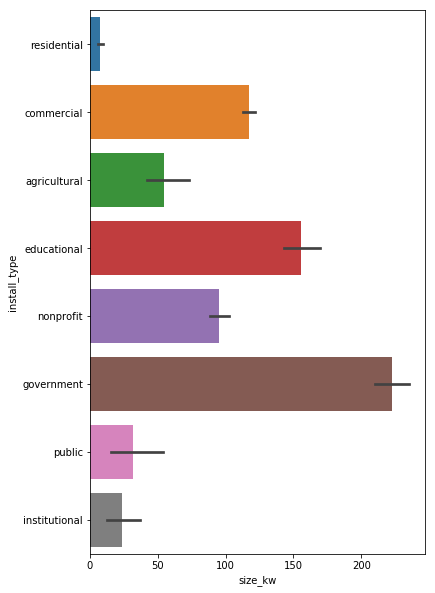

In [69]:
fig = plt.figure(figsize=(6,10))
sns.barplot(y=df.loc[df['install_type'] != 'utility', 'install_type'],
            x=df.loc[df['install_type'] != 'utility','size_kw'], orient='h')

In [70]:
df.install_type.value_counts()

residential      908118
commercial        36436
government         5748
nonprofit          4220
educational        2703
agricultural        441
utility             230
institutional        29
public               28
Name: install_type, dtype: int64

> I'll just make cutoffs for utility because it's such a standout, then residential, commercial, and government.

 - utility if > utility cuttoff
 - governement if <= utility cutoff and > education max
 - commercial if <= education max and > institutional max
 - residuential if <= instutional max

In [71]:
utility_cutoff = df.loc[df['install_type'] == 'utility', 'size_kw'].max()
education_max = df.loc[df['install_type'] == 'educational', 'size_kw'].max()
instit_max = df.loc[df['install_type'] == 'institutional', 'size_kw'].max()

def install_filler(row):
    # this function will go through every row and fill in null values for install_type with a value based on the 
    # size of the installation
    
    # check if row is null.
    if row['install_type'] == np.nan:
        
        # check if there's a size we can go off of.
        if row['size_kw'] == np.nan:
            
            # compare size
            if row['size_kw'] > utility_cutoff:
                row['install_type'] = 'utility'
            elif row['size_kw'] <= utility_cutoff and row['size_kw'] > education_max:
                row['install_type'] = 'government'
            elif row['size_kw'] <= education_max and row['size_kw'] > instit_max:
                row['install_type'] = 'commercial'
            else:
                row['install_type'] = 'residential'
                
    return row 

In [72]:
df = df.apply(install_filler, axis=1)

In [73]:
# forgot to fill ones that don't have a size with residential.

df.install_type.isnull().sum()

62765

In [74]:
df.install_type.fillna(value='residential', inplace=True)

In [75]:
df.install_type.isnull().sum()

0

In [76]:
df.install_type.value_counts()

residential      970883
commercial        36436
government         5748
nonprofit          4220
educational        2703
agricultural        441
utility             230
institutional        29
public               28
Name: install_type, dtype: int64

In [78]:
# saving to the database.
df.to_csv('open_pv_clean_backup.csv')

### Appraised

In [79]:
df.appraised.value_counts()

True           212129
True            11907
5.560623646         2
5.572553158         1
Name: appraised, dtype: int64

In [80]:
# I'm going to change this to a 1 / 0 ohe situation.

df.appraised.fillna(0, inplace=True)

In [87]:
df.appraised.value_counts()

0              796679
1              212129
True            11907
5.560623646         2
5.572553158         1
Name: appraised, dtype: int64

In [84]:
mask = df.appraised == True
df.loc[mask, 'appraised'] = 1

### Zipcode and address information

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020718 entries, 0 to 1020717
Data columns (total 40 columns):
Unnamed: 0                     1020715 non-null float64
state                          1020718 non-null object
date_installed                 1020712 non-null object
incentive_prog_names           1020717 non-null object
type                           1020713 non-null object
size_kw                        1020713 non-null float64
appraised                      1020718 non-null object
zipcode                        1020710 non-null float64
install_type                   1020718 non-null object
installer                      702647 non-null object
cost_per_watt                  763136 non-null object
cost                           763294 non-null float64
lbnl_tts_version_year          797959 non-null object
lbnl_tts                       797959 non-null object
city                           799149 non-null object
utility_clean                  1020713 non-null object
tech_1   

In [89]:
df.loc[df['zipcode'].isnull(), :]

,Unnamed: 0,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,...,reported_annual_energy_prod,year,pbi_length,utility,bipv_3,bipv_2,bipv_1,new_constr,tracking,3rdparty
627,627.0,IN,NaN,no_incentive_program,NaN,NaN,0,NaN,residential,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283268,283268.0,OH,NaN,no_incentive_program,NaN,NaN,0,NaN,residential,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283285,283285.0,PA,NaN,no_incentive_program,NaN,NaN,0,NaN,residential,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283456,283456.0,OH,NaN,no_incentive_program,NaN,NaN,0,NaN,residential,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283475,283475.0,PA,NaN,no_incentive_program,NaN,NaN,0,NaN,residential,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678722,NaN,Los Angeles Department of Water & Power,Mono,OPT325-72-4-100,Los Angeles,707151.5436,5.560623646,NaN,residential,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
679288,NaN,Los Angeles Department of Water & Power,NaN,NaN,Los Angeles,255673.1799,5.572553158,NaN,residential,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
885190,NaN,Los Angeles Department of Water & Power,Poly,CS6P-250P,Los Angeles,172936.1267,5.560623646,NaN,residential,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> looks like these are just too complex so let's drop these.

In [90]:
df = df.loc[df['zipcode'].notnull(), :]

In [91]:
df.to_csv('open_pv_clean.csv')

### Installer

In [92]:
df.installer.value_counts()

SolarCity                                 168125
Vivint                                     41615
Sunpower                                   19925
Verengo                                    16396
Sungevity                                  14939
Rec Solar                                  14291
PetersenDean                               11235
RGS/Real Goods                             10951
Sunrun                                      9968
Grid Alternatives                           8119
Trinity Heating & Air                       7966
Roof Diagnostics Solar & Electric           6012
Self                                        5345
American Solar Direct                       4917
Direct Energy Solar                         4761
American Solar Electric                     4453
Future Energy Corp                          4215
Sullivan Solar Power                        4186
Baker Electric                              3591
Solar Service Center                        3295
A1 Solar Power      

> installer is probably going to be regionally dependent, so maybe we can just do something similar to utility?

In [97]:
mask = df['county'] == "Alameda"
county_installers = pd.DataFrame(df.loc[mask, :].groupby(['installer']).size()).sort_values(0, ascending=False)
county_installers

,0
installer,
SolarCity,4145
Sungevity,993
PetersenDean,799
Solar Company,496
Sun Light & Power,436
Vivint,381
Rec Solar,361
Grid Alternatives,294
RGS/Real Goods,289


> doesn't look like there's necesarily a clear connection between county and installer.

In [98]:
sc_percent = 4145./sum(county_installers.values)[0]

In [95]:
sc_percent

0.2679206256867688

> solar city is 4 times bigger than the next biggest installer in alameda county and yet only as 26% of the installations.

In [99]:
len(df.installer.value_counts())

10958

> also, there's 10k installers... This is a very large value to be used as a feature.

In [102]:
state_installers = []

for state in states:
    non_nulls = df.loc[df['state'] == state, 'installer'].notnull().sum()
    mode_installer = None
    if non_nulls == 0:
        print(state, "no installers", 0)
        mode_installer = "no installers"
    else:
        percent_biggest = float(df.loc[df['state'] == state, 'installer'].value_counts().values[0])/sum(df.loc[df['state'] == state, 'installer'].value_counts().values)
        print(state, df.loc[df['state'] == state, 'installer'].value_counts().index[0], percent_biggest)
        mode_installer = df.loc[df['state'] == state, 'installer'].value_counts().index[0]
    state_installers.append({
        "state": state,
        "mode_installer": mode_installer
    }
    )

state_mode_installers = pd.DataFrame(state_installers)
state_mode_installers

TX Advanced Solar & Electric 0.21459747817652763
IN Whole Sun Designs Inc 0.2334096109839817
CA SolarCity 0.22479790241619602
OK Paradise Energy Solutions 1.0
OH Paradise Energy Solutions 0.88
IL Solar Service 0.11616161616161616
MI no installers 0
VA Paradise Energy Solutions 0.8636363636363636
WI Arch Electric - 297 0.09651898734177215
CO no installers 0
MD SolarCity 0.1695865451997197
FL Solar Impact 0.11544628540887227
NY Paradise Energy Solutions 0.7171717171717171
MA SolarCity 0.2862848665655923
PA Direct Energy Solar 0.07052054061287301
AZ SolarCity 0.4263691110971708
UT no installers 0
KY Morton Solar, LLC 0.7777777777777778
DE Sungevity 0.16869095816464239
WA no installers 0
IA Ideal Energy 0.9137931034482759
MS no installers 0
HI no installers 0
KS SoCore Energy 1.0
GA no installers 0
ME ReVision Energy 0.5652173913043478
NH Revision Energy 0.5827067669172933
CT SolarCity 0.3188865828348187
VT Integrated Solar and REC Solar 1.0
NM Consolidated Solar Technologies 0.20312256049

,mode_installer,state
0,Advanced Solar & Electric,TX
1,Whole Sun Designs Inc,IN
2,SolarCity,CA
3,Paradise Energy Solutions,OK
4,Paradise Energy Solutions,OH
5,Solar Service,IL
6,no installers,MI
7,Paradise Energy Solutions,VA
8,Arch Electric - 297,WI
9,no installers,CO


In [103]:
df['installer'].value_counts()

SolarCity                                 168125
Vivint                                     41615
Sunpower                                   19925
Verengo                                    16396
Sungevity                                  14939
Rec Solar                                  14291
PetersenDean                               11235
RGS/Real Goods                             10951
Sunrun                                      9968
Grid Alternatives                           8119
Trinity Heating & Air                       7966
Roof Diagnostics Solar & Electric           6012
Self                                        5345
American Solar Direct                       4917
Direct Energy Solar                         4761
American Solar Electric                     4453
Future Energy Corp                          4215
Sullivan Solar Power                        4186
Baker Electric                              3591
Solar Service Center                        3295
A1 Solar Power      

In [104]:
df.columns

Index(['Unnamed: 0', 'state', 'date_installed', 'incentive_prog_names', 'type',
       'size_kw', 'appraised', 'zipcode', 'install_type', 'installer',
       'cost_per_watt', 'cost', 'lbnl_tts_version_year', 'lbnl_tts', 'city',
       'utility_clean', 'tech_1', 'model1_clean', 'county', 'annual_PV_prod',
       'annual_insolation', 'rebate', 'sales_tax_cost', 'tilt1',
       'tracking_type', 'azimuth1', 'manuf2_clean', 'manuf3_clean',
       'manuf1_clean', 'inv_man_clean', 'reported_annual_energy_prod', 'year',
       'pbi_length', 'utility', 'bipv_3', 'bipv_2', 'bipv_1', 'new_constr',
       'tracking', '3rdparty'],
      dtype='object')

> Interesting, looks like solarcity doesn't install many mono systems, maybe we can assign all the blanks to solarcity if they're not mono, and see who the biggest installer is for mono and assign the rest to that one.


In [105]:
# should go work on tech_1 next, this seems really important.
df.loc[df['installer'] == 'SolarCity', 'tech_1'].value_counts()

Poly           121271
crystalline      2664
Mono             2658
CdTe              585
Mono + a-Si       297
CIGS                8
a-Si                3
Name: tech_1, dtype: int64

In [106]:
df.loc[df['tech_1'] == 'Mono', 'installer'].value_counts()

Sunpower                             14743
RGS/Real Goods                        5156
Verengo                               4768
PetersenDean                          4339
Sungevity                             4107
Future Energy Corp                    3349
Trinity Heating & Air                 3135
Baker Electric                        2855
Solar Company                         2760
SolarCity                             2658
A1 Solar Power                        2356
Sullivan Solar Power                  1790
Semper Solaris Construction           1724
Akeena                                1633
Self                                  1572
Leonard Roofing                       1566
Direct Energy Solar                   1350
Acro Energy Technologies              1262
American Solar Electric               1131
Cobalt Power Systems                  1100
Roof Diagnostics Solar & Electric     1067
Solar West Electric                   1044
Natural Energy                        1018
Smart Energ

> Sunpower appears to be far and away the biggest installer of these kind.

In [107]:
df.loc[df['tech_1'] == 'Mono', 'installer'].notnull().sum()

190004

In [108]:
df.loc[df['tech_1'] == 'Mono', 'installer'].value_counts()

Sunpower                             14743
RGS/Real Goods                        5156
Verengo                               4768
PetersenDean                          4339
Sungevity                             4107
Future Energy Corp                    3349
Trinity Heating & Air                 3135
Baker Electric                        2855
Solar Company                         2760
SolarCity                             2658
A1 Solar Power                        2356
Sullivan Solar Power                  1790
Semper Solaris Construction           1724
Akeena                                1633
Self                                  1572
Leonard Roofing                       1566
Direct Energy Solar                   1350
Acro Energy Technologies              1262
American Solar Electric               1131
Cobalt Power Systems                  1100
Roof Diagnostics Solar & Electric     1067
Solar West Electric                   1044
Natural Energy                        1018
Smart Energ

In [109]:
df.loc[df['state'] == 'IL', 'installer'].value_counts()

Solar Service                                  46
Kapital Electric                               32
Solar Energy Of Illinois                       28
Ailey Solar Electric                           22
Earth Wind & Solar Energy                      22
Self                                           20
Renewable Energy Alternatives                  18
Tick Tock Energy                               16
Day & Night Solar                              14
Nadler Electrical Contracting                  13
Central Illinois Wind & Solar                  13
Straightup Solar                               12
Wcp Solar Services                             12
Sunair Systems                                 11
Windfree Wind & Solar                          10
Tropic Construction                             7
Morton Solar                                    7
Title Electric Company                          6
Renewable Alternative Energy                    5
Magitek Energy Solutions                        5


In [110]:
# want to go through each row, and fill in with the mode installer in the state if there is one.
# if there isn't, fill with Sunpower if the tech_1 is mono, else fill with solarcity.

state_installers = {}

states = list(df.state.unique())

for state in states:
    non_nulls = df.loc[df['state'] == state, 'installer'].notnull().sum()
    mode_installer = None
    if non_nulls == 0:
        mode_installer = "no installers"
    else:
        mode_installer = df.loc[df['state'] == state, 'installer'].value_counts().index[0]
    state_installers[state] = mode_installer

In [111]:
df.installer.isnull().sum()

318063

In [112]:
def fill_installer(row):
    # check to see if the installer category is null
    if row['installer'] is None:
        
        # checking if there are no installers listed in the state on this row.
        if state_installers[row['state']] == 'no installers':
            
            # if there are, check to see if tech is mono.
            if row['tech_1'] == "Mono":
                row['installer'] == "Sunpower"
            else:
                row['installer'] == "SolarCity"
        # if not no_installers, then we'll just set the null value to the mode installer from the state.
        else:    
            
            row['installer'] = state_installers[row['state']]
    
    return row

In [113]:
df = df.apply(fill_installer, axis=1)

In [114]:
df.to_csv("open_pv_clean.csv")

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!